In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install fastparquet
!python3 -m pip install  python-snappy
!sudo apt-get install libsnappy-dev
!pip install tensorflow-addons
!python3 -m pip install pyarrow
! pip install hyperas
!pip install --upgrade numpy

     |████████████████████████████████| 1.2 MB 2.7 MB/s 
     |████████████████████████████████| 59 kB 7.9 MB/s 
     |████████████████████████████████| 1.5 MB 71.2 MB/s 
     |████████████████████████████████| 125 kB 92.6 MB/s 
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=348185 sha256=4c9a5eec2b34bdeb65523f691bc653361e3e8d57f820d49a5e77c5837a0110b6
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift
     |████████████████████████████████| 55 kB 2.2 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsnappy-dev
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 27.2 kB of archives.
After this operation, 108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy-dev amd64 1.1.7-1 [27.2 kB]
F

# Import the data 

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import fastparquet as fp
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from scipy.integrate import trapz
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Deep Learning libraries
import tensorflow as tf
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.activations import mish
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom libraries
os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from from_cytoclus_to_curves_values import extract_labeled_curves, extract_non_labeled_curves
from dataset_preprocessing import homogeneous_cluster_names_swings, gen_train_test_valid
from viz_functions import plot_2Dcyto

current_dir = '/content/gdrive/My Drive/data/SWINGS/L2/Pulse/'

          
os.chdir('/content/gdrive/My Drive/data/SWINGS')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
train = np.load(current_dir + 'train.npz', allow_pickle = True)
valid = np.load(current_dir + 'valid.npz', allow_pickle = True)

X_train = train['X']
X_valid = valid['X']

y_train = train['y']
y_valid = valid['y']

# Free the memory 
del(train)
del(valid)

In [5]:
# Import the test set
test = np.load(current_dir + 'test.npz', allow_pickle = True)
X_test = test['X']
y_test = test['y']
del(test)

In [ ]:
X_train = X_train / X_train.mean((0 , 1), keepdims = True)
X_valid = X_valid / X_valid.mean((0 , 1), keepdims = True)
X_test = X_test / X_test.mean((0 , 1), keepdims = True)

In [6]:
# Import the nomenclature created by the "gen_train_test_valid" function
tn = pd.read_csv(current_dir + '/train_test_nomenclature.csv')
tn.columns = ['name', 'id']

In [7]:
from scipy.interpolate import interp1d

def quick_preprocessing(df, columns):
  '''
    Preprocess the curves for network predictions (short version of the data_preprocessing function).
    df (pandas DataFrame): The total curves (as in the .parq files)
    ------------------------------------------------------------------
    returns (np.array, list): The formatted curves and the associated class 
    Note: Some Refactoring is needed
  '''

  max_len = 120
  # Reformatting the values
  obs_list = [] # The 5 curves
  #y_list = [] # The class (e.g. 0 = prochlorocchoccus, 1= ...)

  for pid, obs in df.groupby('Particle ID'):
      obs_list.append(obs[columns].values.T)
      #y_list.append(list(set(obs['cluster']))[0])

  #print(obs.columns)
  obs_list = interp_sequences(obs_list, max_len)

  X = np.transpose(obs_list, (0, 2, 1))
  return X#, y_list

def interp_sequences(sequences, max_len):
    ''' Interpolate sequences in order to reduce their length to max_len
        sequences (ndarray): The sequences to interpolate
        maxlen (int): The maximum length of the sequence: All sequences will be interpolated to match this length
        -------------------------------------------------------------------
        returns (ndarray): The interpolated sequences
    '''

    interp_obs = np.zeros((len(sequences), 5, max_len))
    for idx, s in enumerate(sequences):
        original_len = s.shape[1]
        f = interp1d(np.arange(original_len), s, 'quadratic', axis = 1)
        interp_seq = f(np.linspace(0, original_len -1, num = max_len))
        interp_obs[idx] = interp_seq
    
    try:
        return np.stack(interp_obs)
    except ValueError:
        return np.array([])


In [10]:
os.chdir('hardtoclassify/Pulse')
files = os.listdir()

#models = ['Bench', 'BenchBig', 'VGGSmall', 'VGGBig']
sets = files
X_files = {}

In [11]:
files

['Labelled_Pulse20_2021-02-10 13h59.parq',
 'Labelled_Pulse20_2021-02-11 05h59.parq',
 'Labelled_Pulse5_2021-03-02 18h11.parq',
 'Labelled_Pulse5_2021-01-09 08h11.parq',
 'Labelled_Pulse5_2021-01-24 16h11.parq']

In [12]:
pfg_num = 5

for file in files: 
  # Import data
  pfile = fp.ParquetFile(file)
  df = pfile.to_pandas()
  
  X_file = quick_preprocessing(df, columns = ['FWS','SWS', 'Fl Yellow', 'FL Red', 'Curvature'])
  del(df)
  X_files[file] = X_file
  
  # Pred on these data
  #count.loc[file, 'Bench'] = (bench_model.predict(X_file).argmax(1) == pfg_num).sum()
  #count.loc[file, 'BenchBig'] = (bench_big.predict(X_file).argmax(1) == pfg_num).sum()
  #count.loc[file, 'VGGSmall'] = (VGG_small.predict(X_file).argmax(1) == pfg_num).sum() 
  #count.loc[file, 'VGGBig'] = (VGG_big.predict(X_file).argmax(1) == pfg_num).sum()
  #count.loc[file, 'Baroud'] = (baroud.predict(X_file).argmax(1) == pfg_num).sum()
  #print(count)

In [13]:
Xit_files = {}

for file in files:
  XX = pd.DataFrame(trapz(X_files[file], axis = 1), columns = ['FWS', 'SWS', 'FLY', 'FLR', 'Curvature'])
  Xit_files[file] = XX

# Training the model

In [14]:
# Load the model 
from keras.models import load_model
bench_model = load_model('/content/gdrive/My Drive/Models/SWINGS/cnn_small')
#bench_model.load_weights('/content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt.hdf5')

In [ ]:
sb_weights = '/content/gdrive/My Drive/Models/SWINGS/small_bench_weights3.hdf5'

In [ ]:
dp = 0.0583#{{uniform(0, 0.5)}}

N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
x = tf.keras.layers.Conv1D(16, 5, activation='relu')(sequence_input)
x = tf.keras.layers.Conv1D(8, 5, activation='relu')(x)

# Average those features
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x) 
x = tf.keras.layers.Dropout(dp)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(dp)(x)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(x)
bench_model = tf.keras.Model(sequence_input, predictions)


#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=sb_weights,\
                        verbose = 1, save_best_only=True)


lr = 0.00105

sync_period = 6
slow_step_size = 0.680797 
rad = RectifiedAdam(learning_rate = lr)
optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 'regular'

if weights == 'regular':
    w = np.full(N_CLASSES, 1 / N_CLASSES)
    #w = w / w.sum()

else:
    w = 1 / np.sqrt(np.sum(y_train, axis = 0))
    w = w / w.sum()

w = dict(zip(range(N_CLASSES),w))

batch_size = 32
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (64 * 8)) + 1


bench_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
bench_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 120, 5)]          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 118, 32)           512       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 116, 32)           3104      
_________________________________________________________________
average_pooling1d_6 (Average (None, 58, 32)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 56, 64)            6208      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 54, 64)            12352     
_________________________________________________________________
average_pooling1d_7 (Average (None, 27, 64)            0   

In [ ]:
result_sb = bench_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])

bench_model.load_weights(sb_weights)

Labelled_Pulse20_2021-02-10 13h59.parq
{'REDPICOEUK': 56456, 'sup1microm': 2507, 'MICRO': 3663, 'inf1microm': 9926, 'REDNANO': 8381, 'ORGPICOPRO': 4202, 'ORGNANO': 167, 'REDPICOPRO': 22}


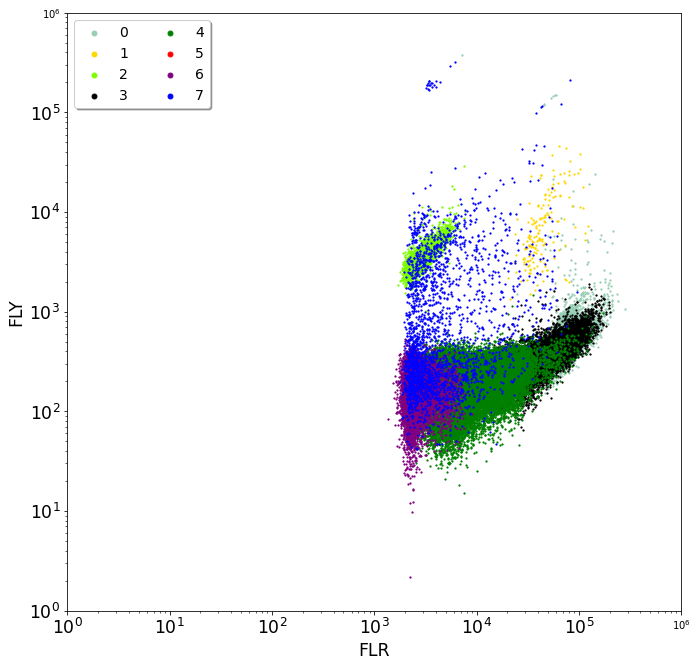

Labelled_Pulse20_2021-02-11 05h59.parq
{'REDPICOEUK': 73606, 'MICRO': 1754, 'inf1microm': 10596, 'ORGPICOPRO': 7919, 'REDNANO': 9948, 'sup1microm': 3086, 'ORGNANO': 416, 'REDPICOPRO': 34}


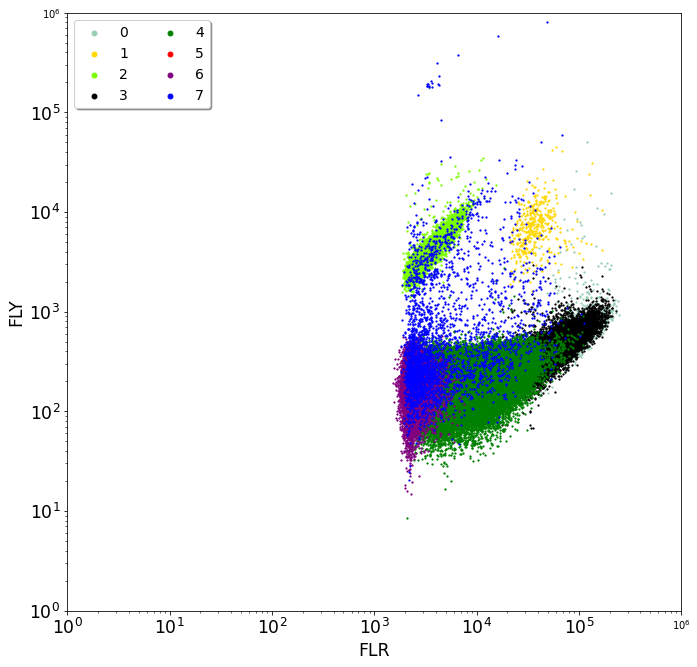

Labelled_Pulse5_2021-03-02 18h11.parq
{'ORGPICOPRO': 93233, 'inf1microm': 34985, 'REDPICOPRO': 34245, 'REDPICOEUK': 10803, 'REDNANO': 689, 'sup1microm': 3032, 'ORGNANO': 69, 'MICRO': 74}


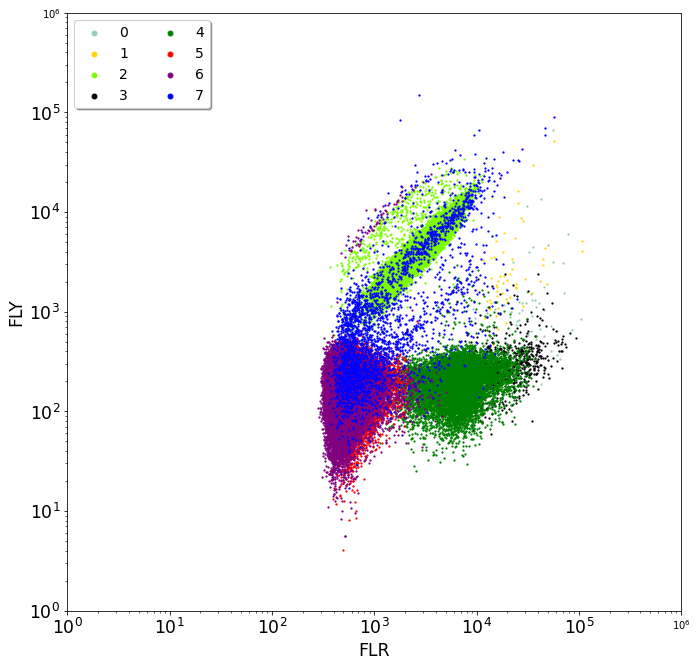

Labelled_Pulse5_2021-01-09 08h11.parq
{'inf1microm': 470337, 'REDPICOPRO': 18015, 'REDPICOEUK': 1270, 'ORGPICOPRO': 1220, 'sup1microm': 5833, 'MICRO': 23, 'REDNANO': 247, 'ORGNANO': 12}


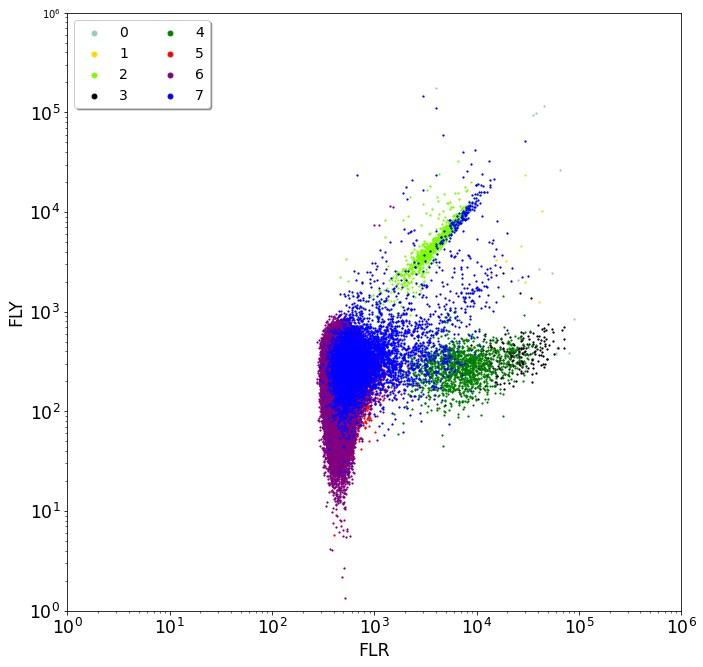

Labelled_Pulse5_2021-01-24 16h11.parq
{'inf1microm': 66121, 'REDPICOEUK': 2989, 'ORGPICOPRO': 15675, 'REDPICOPRO': 24790, 'REDNANO': 405, 'sup1microm': 813, 'MICRO': 19, 'ORGNANO': 4}


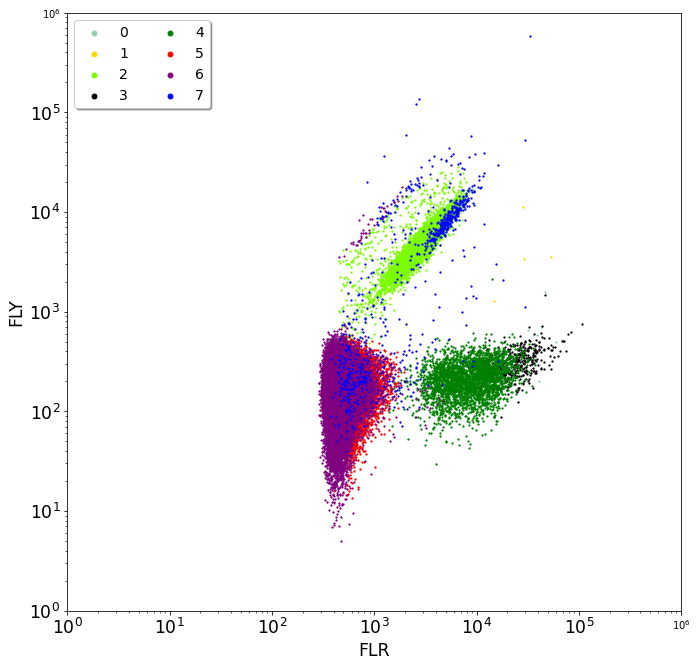

In [15]:
pfg_num = 5
count = pd.DataFrame(index = sets, columns = ['Bench'])

for file in files: 
  print(file)
  # Pred on these data
  preds = bench_model.predict(X_files[file]).argmax(1)
  print({tn[tn['id'] == int(k)]['name'].values[0]: v for k, v in Counter(preds).items()})
  count.loc[file, 'Bench'] = (preds == pfg_num).sum()
  yy = bench_model.predict(X_files[file]).argmax(1).astype(str)
  #yy  = [tn[tn['id'] == int(y_)]['name'] for y_ in yy]
  plot_2Dcyto(Xit_files[file], yy, q1 = 'FLR', q2 = 'FLY', str_labels = True)

In [23]:
X_files['Labelled_Pulse5_2021-03-02 18h11.parq'].shape

(177130, 120, 5)

# Import test data

### Test set

In [ ]:
models = ['Bench']
sets = ['Train', 'Valid', 'Test']
micro_acc = pd.DataFrame(index = sets, columns = models)
macro_acc = pd.DataFrame(index = sets, columns = models)
conf_mtx = {}
per_class_acc = pd.DataFrame()
per_class_rec = pd.DataFrame()

In [ ]:
preds = {}
preds['Bench'] = bench_model.predict(X_test)

In [ ]:
conf_mtx['Test'] = {}
y_test_max = y_test.argmax(1)

for spe, preds_ in preds.items():
  preds_spe_max = preds_.argmax(1)
  class_accuracy = precision_score(y_test_max, preds_spe_max,\
                                  average = None, labels = list(range(y_test.shape[1])))
  class_recall = recall_score(y_test_max, preds_spe_max,\
                                  average = None, labels = list(range(y_test.shape[1])))

  micro_acc.loc['Test', spe] = precision_score(y_test_max, preds_spe_max,\
                                  average = 'micro', labels = list(range(y_test.shape[1])))
  macro_acc.loc['Test', spe] = precision_score(y_test_max, preds_spe_max,\
                                  average = 'macro', labels = list(range(y_test.shape[1])))
    
  c_acc = pd.DataFrame(index = tn['name'], data = class_accuracy, columns = [spe + '_Test'])
  c_rec = pd.DataFrame(index = tn['name'], data = class_recall, columns = [spe + '_Test'])

  per_class_acc = per_class_acc.join(c_acc, how = 'right')    
  per_class_rec = per_class_rec.join(c_rec, how = 'right')    

  conf_mtx['Test'][spe] = pd.DataFrame(confusion_matrix(y_test_max, preds_spe_max,\
                      labels = tn['id']), index = tn['name'], columns =  tn['name'])
  

# Print the results

In [ ]:
print(micro_acc.T)
print(macro_acc.T)
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(per_class_rec)
print(per_class_acc)

      Train Valid      Test
Bench   NaN   NaN  0.986294
      Train Valid     Test
Bench   NaN   NaN  0.92702
            Bench_Test
name                  
MICRO         1.000000
ORGNANO       0.655462
ORGPICOPRO    0.991634
REDNANO       0.960790
REDPICOEUK    0.982261
REDPICOPRO    0.958038
inf1microm    0.993780
sup1microm    0.972605
            Bench_Test
name                  
MICRO         0.752577
ORGNANO       0.962963
ORGPICOPRO    0.992389
REDNANO       0.850374
REDPICOEUK    0.996503
REDPICOPRO    0.945271
inf1microm    0.995880
sup1microm    0.920199


In [ ]:
print(micro_acc.T)
print(macro_acc.T)
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(per_class_rec)
print(per_class_acc)

      Train Valid      Test
Bench   NaN   NaN  0.980938
      Train Valid      Test
Bench   NaN   NaN  0.901817
            Bench_Test
name                  
MICRO         0.949772
ORGNANO       0.747899
ORGPICOPRO    0.994803
REDNANO       0.936963
REDPICOEUK    0.984843
REDPICOPRO    0.831366
inf1microm    0.993190
sup1microm    0.934548
            Bench_Test
name                  
MICRO         0.888889
ORGNANO       0.618056
ORGPICOPRO    0.984693
REDNANO       0.842898
REDPICOEUK    0.990709
REDPICOPRO    0.957415
inf1microm    0.987127
sup1microm    0.944748


In [ ]:
print(micro_acc.T)
print(macro_acc.T)
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(per_class_rec)

print(per_class_rec)

      Train Valid      Test
Bench   NaN   NaN  0.984391
      Train Valid      Test
Bench   NaN   NaN  0.896272
            Bench_Test
name                  
MICRO         0.990868
ORGNANO       0.823529
ORGPICOPRO    0.987831
REDNANO       0.942995
REDPICOEUK    0.985540
REDPICOPRO    0.956858
inf1microm    0.990936
sup1microm    0.940621
            Bench_Test
name                  
MICRO         0.990868
ORGNANO       0.823529
ORGPICOPRO    0.987831
REDNANO       0.942995
REDPICOEUK    0.985540
REDPICOPRO    0.956858
inf1microm    0.990936
sup1microm    0.940621


In [ ]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

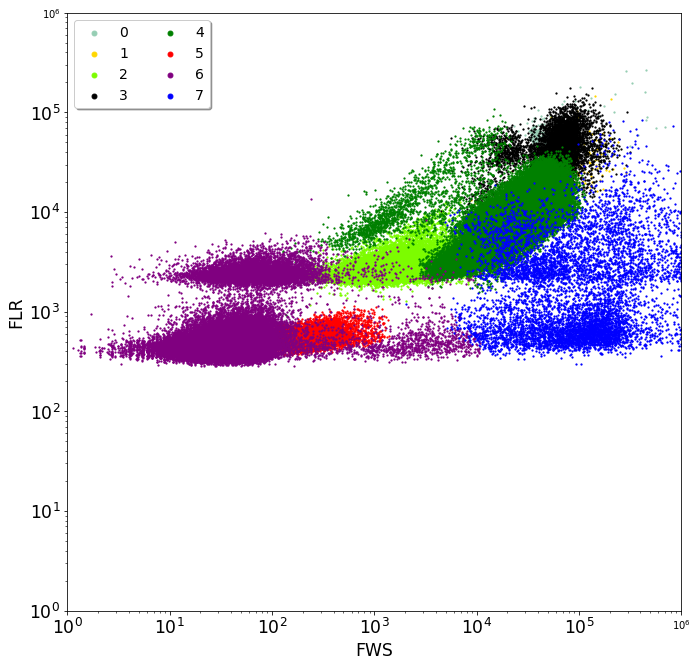

In [ ]:
XX_test =  pd.DataFrame(trapz(X_test, axis = 1), columns = ['FWS', 'SWS', 'FLY', 'FLR', 'Curvature'])
plot_2Dcyto(XX_test, y_test.argmax(1).astype(str), q1 = 'FWS', q2 = 'FLR', str_labels = True)


In [ ]:
dp = 0.0583#{{uniform(0, 0.5)}}

N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(sequence_input)
x = tf.keras.layers.Conv1D(32, 5, activation='relu')(x)
x = tf.keras.layers.Conv1D(16, 5, activation='relu')(x)

# Average those features
average = tf.keras.layers.GlobalAveragePooling1D()(x)
dense2 = tf.keras.layers.Dense(32, activation='relu')(average) 
drop2 = tf.keras.layers.Dropout(dp)(dense2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(dp)(dense3)
dense4 = tf.keras.layers.Dense(16, activation='relu')(drop3)
drop4 = tf.keras.layers.Dropout(dp)(dense4)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(drop4)

model = tf.keras.Model(sequence_input, predictions)


#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath='w_categ_hyperopt3.hdf5',\
                        verbose = 1, save_best_only=True)


lr = 0.00105

sync_period = 6
slow_step_size = 0.680797 
rad = RectifiedAdam(lr = lr)
optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 'regular'

if weights == 'regular':
    w = np.full(N_CLASSES, 1 / N_CLASSES)
    #w = w / w.sum()

else:
    w = 1 / np.sqrt(np.sum(y_train, axis = 0))
    w = w / w.sum()

w = dict(zip(range(N_CLASSES),w))

batch_size = 64
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (64 * 8)) + 1


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)



In [ ]:
result = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 60, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])


#Get the highest validation accuracy of the training epochs
loss_acc = np.amin(result.history['val_loss'])
print('Min loss of epoch:', loss_acc)
model.load_weights('w_categ_hyperopt3.hdf5')
